In [38]:
import numpy as np
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
from scipy import interpolate
import scipy.signal
import glob
import re
import matplotlib.image as mpimg

import sys
sys.path.append('../')
from functions import *

In [39]:
save_images = False

In [40]:
def rotation(x_arr,y_arr,angle):
    """Rotates a point around the origin (0,0) in the clockwise direction. 
       Angle is in radians. Point is a tuple"""
    x_rot_arr, y_rot_arr = (x_arr*np.cos(angle)+y_arr*np.sin(angle),-x_arr*np.sin(angle)+y_arr*np.cos(angle))
    return x_rot_arr, y_rot_arr

def curvature(x_path, y_path,scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r

## WT

In [51]:
path = "../../dat/WT_manip_20210722"
cells = sorted(glob.glob("%s/*"%path))
cells = [cell for cell in cells if not 'Icon' in cell]

CminC_pos_ls,Cmax_pos_ls = [],[]
Cmax_val_ls,CminC_val_ls = [],[]
for n,cell in enumerate(cells):
    spindle = cell.split("/")[-1].split(".")[0]
    image = mpimg.imread("%s/%s_after.tif"%(cell,spindle))
    profile = glob.glob("%s/kfiber.csv"%cell)[0]

    df_dat = pd.read_csv(profile)
    
    x_dat_ls = df_dat["X"].values
    y_dat_ls = df_dat["Y"].values


    angle = np.arctan((y_dat_ls[-1] - y_dat_ls[0]) / (x_dat_ls[-1] - x_dat_ls[0]))
    x_dat_ls,y_dat_ls = rotation(x_dat_ls,y_dat_ls,angle)

    # Translation to start at origin
    x_dat_ls -= x_dat_ls[0]
    y_dat_ls -= y_dat_ls[0]

    # Flipping to ensure a positive initial slope
    theta0 = np.arctan2(y_dat_ls[3]-y_dat_ls[0],x_dat_ls[3]-x_dat_ls[0])
    if theta0 < 0.0:
        y_dat_ls = -y_dat_ls
        angle = -angle
#         print("Angle of P-K rotation =  %.2f degrees" %np.degrees(angle))

    # Convert from pixel to micron units based on scope camera calibration

    if '2017' in spindle:
        scope_calibration = 0.0657
    elif '2021' in spindle:
        scope_calibration = 0.0657
    else:
        scope_calibration = 0.105

    x_dat_ls = x_dat_ls*scope_calibration
    y_dat_ls = y_dat_ls*scope_calibration
    
    L = x_dat_ls[-1] - x_dat_ls[0]
    x_dat_ls = L - x_dat_ls
    x_dat_ls = np.flip(x_dat_ls)
    y_dat_ls = np.flip(y_dat_ls)
    
    y_needle = np.max(y_dat_ls)
    x_needle = x_dat_ls[np.where(y_dat_ls == np.max(y_dat_ls))]
    xF = x_needle[0]
    
    iF_dat = np.where(x_dat_ls > xF)[0][0]
    s_dat_ls,L_contour_dat = contour_fn(x_dat_ls,y_dat_ls)

    window = 10
    C_dat_ls = curvature(x_dat_ls, y_dat_ls,window)

    C_max_ind = np.where(C_dat_ls == np.max(C_dat_ls))[0][0]+window
    C_minC_ind = np.where(C_dat_ls == np.min(C_dat_ls[0:iF_dat]))[0][0]+window
    Cmax_pos_ls.append(s_dat_ls[C_max_ind])
    Cmax_val_ls.append(C_dat_ls[C_max_ind-window])
    CminC_pos_ls.append(s_dat_ls[C_minC_ind])
    CminC_val_ls.append(C_dat_ls[C_minC_ind-window])
#     kfib_len_ls.append(s_dat_ls[-1])

#     plt.scatter(x_dat_ls[window:-window],y_dat_ls[window:-window],c=C_dat_ls,cmap = "coolwarm", vmin = -1,vmax = 1)
#     plt.show()

CminC_val_WT = CminC_val_ls
Cmax_val_WT = Cmax_val_ls


In [52]:
# Cmax_pos_ls = np.array(Cmax_pos_ls)
# CminC_pos_ls = np.array(CminC_pos_ls)

# nbins = np.array([2,4,6,8,10])
# n, _ = np.histogram(Cmax_pos_ls, bins=nbins)
# sy, _ = np.histogram(Cmax_pos_ls, bins=nbins, weights=CminC_pos_ls)
# sy2, _ = np.histogram(Cmax_pos_ls, bins=nbins, weights=CminC_pos_ls*CminC_pos_ls)
# mean = sy / n
# std = np.sqrt(sy2/n - mean*mean)

# # plt.figure(figsize=(15,15))
# plt.figure(figsize=(5,5))
# plt.scatter(Cmax_pos_ls,CminC_pos_ls, s=70, color='lightgray',ec='k')
# plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)

# for i,cell in enumerate(cells):
#     spindle = cell.split("/")[-1].split(".")[0]
# #     plt.annotate(spindle, (Cmax_pos_ls[i], CminC_pos_ls[i]))

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlim(0,10)
# plt.ylim(0,10)
# plt.axhline(3,color='k', ls = '--',lw = 1)
# plt.tight_layout()
# plt.savefig("fig_outputs/WT_experimental_data_new.pdf")
# plt.show()



## FCPT

In [53]:
path = "../../dat/FCPT_manip_20210812"# FCPT_manip_20210812, WT_manip_20210722
cells = sorted(glob.glob("%s/*"%path))
cells = [cell for cell in cells if not 'Icon' in cell]

CminC_pos_ls,Cmax_pos_ls,CminP_pos_ls,kfib_len_ls = [],[],[],[]
Cmax_val_ls, CminC_val_ls = [],[]
for n,cell in enumerate(cells):
    try:
        spindle = cell.split("/")[-1].split(".")[0]
        image = mpimg.imread("%s/%s_after.tif"%(cell,spindle))
        profile = glob.glob("%s/kfiber.csv"%cell)[0]

        df_dat = pd.read_csv(profile)

        x_dat_ls = df_dat["X"].values
        y_dat_ls = df_dat["Y"].values


        angle = np.arctan((y_dat_ls[-1] - y_dat_ls[0]) / (x_dat_ls[-1] - x_dat_ls[0]))
        x_dat_ls,y_dat_ls = rotation(x_dat_ls,y_dat_ls,angle)

        # Translation to start at origin
        x_dat_ls -= x_dat_ls[0]
        y_dat_ls -= y_dat_ls[0]

        # Flipping to ensure a positive initial slope
        theta0 = np.arctan2(y_dat_ls[3]-y_dat_ls[0],x_dat_ls[3]-x_dat_ls[0])
        if theta0 < 0.0:
            y_dat_ls = -y_dat_ls
            angle = -angle
    #         print("Angle of P-K rotation =  %.2f degrees" %np.degrees(angle))

        # Convert from pixel to micron units based on scope camera calibration
        if '2017' in spindle:
            scope_calibration = 0.0657
        elif '2021' in spindle:
            scope_calibration = 0.0657
        else:
            scope_calibration = 0.105

        x_dat_ls = x_dat_ls*scope_calibration
        y_dat_ls = y_dat_ls*scope_calibration

        L = x_dat_ls[-1] - x_dat_ls[0]
        x_dat_ls = L - x_dat_ls
        x_dat_ls = np.flip(x_dat_ls)
        y_dat_ls = np.flip(y_dat_ls)

        y_needle = np.max(y_dat_ls)
        x_needle = x_dat_ls[np.where(y_dat_ls == np.max(y_dat_ls))]
        xF = x_needle[0]

        iF_dat = np.where(x_dat_ls > xF)[0][0]
        s_dat_ls,L_contour_dat = contour_fn(x_dat_ls,y_dat_ls)

        window = 10
        C_dat_ls = curvature(x_dat_ls, y_dat_ls,window)

        C_max_ind = np.where(C_dat_ls == np.max(C_dat_ls))[0][0]+window
        C_minC_ind = np.where(C_dat_ls == np.min(C_dat_ls[0:iF_dat]))[0][0]+window
        C_minP_ind = np.where(C_dat_ls == np.min(C_dat_ls[iF_dat:]))[0][0]+window
        Cmax_val_ls.append(C_dat_ls[C_max_ind-window])
        Cmax_pos_ls.append(s_dat_ls[C_max_ind])
        CminC_pos_ls.append(s_dat_ls[C_minC_ind])
        CminC_val_ls.append(C_dat_ls[C_minC_ind-window])
        CminP_pos_ls.append(s_dat_ls[C_minP_ind])
        kfib_len_ls.append(s_dat_ls[-1])
    except:
        print(cell)
        continue
#     print(spindle,s_dat_ls[C_max_ind],s_dat_ls[C_min_ind])

#     plt.scatter(x_dat_ls[window:-window],y_dat_ls[window:-window],c=C_dat_ls,cmap = "coolwarm", vmin = -1,vmax = 1)
#     plt.show()

CminC_val_FCPT = CminC_val_ls
Cmax_val_FCPT = Cmax_val_ls


../../dat/FCPT_manip_20210812/FCPT_2021_microneedle


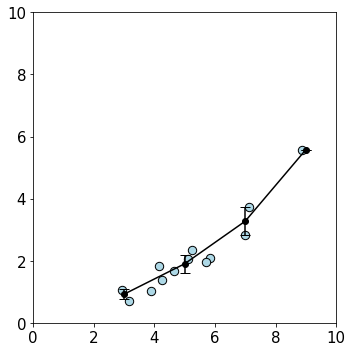

In [54]:
Cmax_pos_ls = np.array(Cmax_pos_ls)
CminC_pos_ls = np.array(CminC_pos_ls)
CminP_pos_ls = np.array(CminP_pos_ls)
kfib_len_ls = np.array(kfib_len_ls)

nbins = np.array([2,4,6,8,10])
n, _ = np.histogram(Cmax_pos_ls, bins=nbins)
sy, _ = np.histogram(Cmax_pos_ls, bins=nbins, weights=CminC_pos_ls)
sy2, _ = np.histogram(Cmax_pos_ls, bins=nbins, weights=CminC_pos_ls*CminC_pos_ls)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

plt.figure(figsize=(5,5))
plt.scatter(Cmax_pos_ls,CminC_pos_ls, s=70, color='lightblue',ec='k')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)
# plt.axhline(3,color='k',ls='--')
# plt.title("curvature minima near chromosome")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,10)
plt.ylim(0,10)

plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/FCPT_experimental_data.pdf")
plt.show()

#########################################
##### pole proximal negative curvature

# n, _ = np.histogram((kfib_len_ls - Cmax_pos_ls), bins=nbins)
# sy, _ = np.histogram((kfib_len_ls - Cmax_pos_ls), bins=nbins, weights=kfib_len_ls - CminP_pos_ls)
# sy2, _ = np.histogram((kfib_len_ls - Cmax_pos_ls), bins=nbins, weights=(kfib_len_ls - CminP_pos_ls)*(kfib_len_ls - CminP_pos_ls))
# mean = sy / n
# std = np.sqrt(sy2/n - mean*mean)

# plt.figure(figsize=(5,5))
# plt.scatter(kfib_len_ls - Cmax_pos_ls,kfib_len_ls - CminP_pos_ls, s=70, color='lightblue',ec='k')
# plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)
# # plt.axhline(3,color='k',ls='--')
# # plt.title("curvature minima near chromosome")
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlim(0,6)
# plt.ylim(0,6)
# plt.show()

# #########################################

# n, _ = np.histogram(Cmax_pos_ls, bins=nbins)
# sy, _ = np.histogram(Cmax_pos_ls, bins=nbins, weights=CminP_pos_ls)
# sy2, _ = np.histogram(Cmax_pos_ls, bins=nbins, weights=CminP_pos_ls*CminP_pos_ls)
# mean = sy / n
# std = np.sqrt(sy2/n - mean*mean)

# plt.figure(figsize=(5,5))
# plt.scatter(Cmax_pos_ls,CminP_pos_ls, s=70, color='lightblue',ec='k')
# plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)
# # plt.axhline(3,color='k',ls='--')
# # plt.title("curvature minima near chromosome")
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlim(0,15)
# plt.ylim(0,15)

# plt.show()


chromosome proximal curvature minima values (WT vs. FCPT)


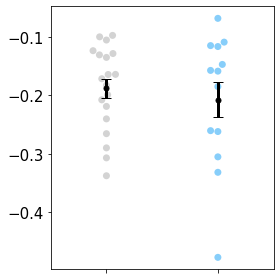

curvature maxima values (WT vs. FCPT)


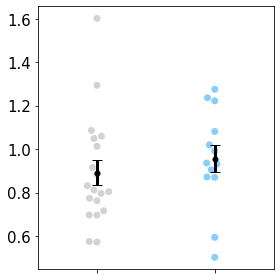

In [66]:
import seaborn as sns

plt.figure(figsize=(4,4))
print("chromosome proximal curvature minima values (WT vs. FCPT)")
var1 = (CminC_val_WT)
var2 = (CminC_val_FCPT)
sns.swarmplot(data=[var1,var2], palette = ["lightgray", "lightskyblue"], size = 7)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
            yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1], ("",""))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(0.01,1)
plt.tight_layout()
plt.show()


plt.figure(figsize=(4,4))
print("curvature maxima values (WT vs. FCPT)")
var1 = (Cmax_val_WT)
var2 = (Cmax_val_FCPT)
sns.swarmplot(data=[var1,var2], palette = ["lightgray", "lightskyblue"], size = 7)
plt.errorbar([0,1],[np.mean(var1),np.mean(var2)],\
            yerr = [np.std(var1)/np.sqrt(len(var1)),np.std(var2)/np.sqrt(len(var2))],
             elinewidth = 3, fmt = '_', color = 'k', marker = '.', markersize = 10, capsize = 5, capthick = 1, zorder = 10)

plt.xticks([0,1], ("",""))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(0.01,1)
plt.tight_layout()
plt.show()


## Displaying example FCPT manipulation images

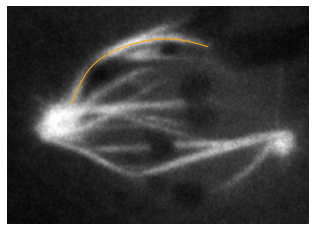

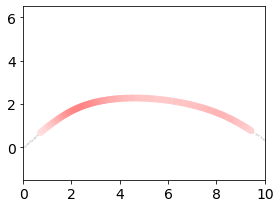

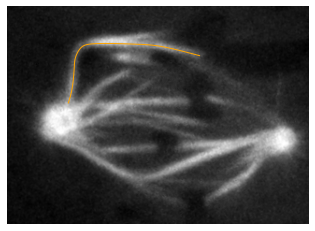

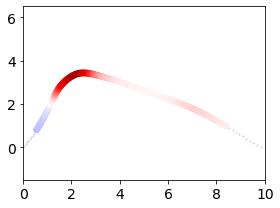

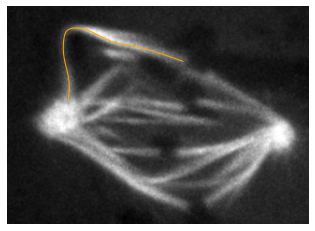

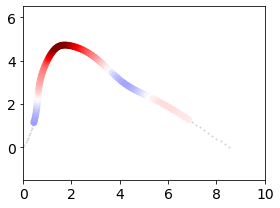

In [29]:
path = "../../dat/FCPT_manip_20210812/20210601_cell001/processed_images"
profiles = sorted(glob.glob("%s/image_sequence*csv"%path))
images =  sorted(glob.glob("%s/t*tif"%path))
CminC_pos_ls,Cmax_pos_ls,CminP_pos_ls,kfib_len_ls = [],[],[],[]

for n,profile in enumerate(profiles):
    image = mpimg.imread(images[n])
    plt.imshow(image,cmap ='gray')
    df_dat = pd.read_csv(profile)
    
    x_dat_ls = df_dat["X"].values
    y_dat_ls = df_dat["Y"].values
#     plt.plot([i-15 for i in x_dat_ls],[i-21 for i in y_dat_ls],color='orange',lw = 1)
    plt.plot([i for i in x_dat_ls],[i for i in y_dat_ls],color='orange',lw = 1)
    plt.axis("off")
    if save_images:
        plt.savefig('fig_outputs/image_%s.pdf'%n)
    plt.show()


    angle = np.arctan((y_dat_ls[-1] - y_dat_ls[0]) / (x_dat_ls[-1] - x_dat_ls[0]))
    x_dat_ls,y_dat_ls = rotation(x_dat_ls,y_dat_ls,angle)

    # Translation to start at origin
    x_dat_ls -= x_dat_ls[0]
    y_dat_ls -= y_dat_ls[0]

#     # Flipping to ensure a positive initial slope
#     theta0 = np.arctan2(y_dat_ls[3]-y_dat_ls[0],x_dat_ls[3]-x_dat_ls[0])
    if theta0 < 0.0:
        y_dat_ls = -y_dat_ls
        angle = -angle
# #         print("Angle of P-K rotation =  %.2f degrees" %np.degrees(angle))

#     # Convert from pixel to micron units based on scope camera calibration
#     scope_calibration = 0.0657

    x_dat_ls = x_dat_ls*scope_calibration
    y_dat_ls = y_dat_ls*scope_calibration
    
#     L = x_dat_ls[-1] - x_dat_ls[0]
#     x_dat_ls = L - x_dat_ls
# #     x_dat_ls = np.flip(x_dat_ls)
# #     y_dat_ls = np.flip(y_dat_ls)
 
    plt.figure(figsize=(4,3))
    window = 10
    C_dat_ls = curvature(x_dat_ls, y_dat_ls,window)
    plt.scatter(x_dat_ls[0:window],y_dat_ls[0:window],c="lightgrey",s = 1)
    plt.scatter(x_dat_ls[-window:],y_dat_ls[-window:],c="lightgrey",s = 1)
    plt.scatter(x_dat_ls[window:-window],y_dat_ls[window:-window],c=C_dat_ls,cmap = "seismic", vmin = -1,vmax = 1)
    plt.xlim(0,10)
    plt.ylim(-1.5,6.5)
#     plt.axis("equal")
    plt.xticks(fontsize=14)
    plt.yticks([0,2,4,6],fontsize=14)
    plt.tight_layout()
#     plt.gca().invert_yaxis()
    if save_images:
        plt.savefig('fig_outputs/curvature_%s.pdf'%n)
    plt.show()
    

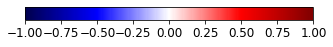

In [62]:
import pylab as pl
import numpy as np

a = np.array([[-1,1]])
pl.figure(figsize=(5,0.3))
img = pl.imshow(a, cmap="seismic")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("fig_outputs/colorbar.pdf")

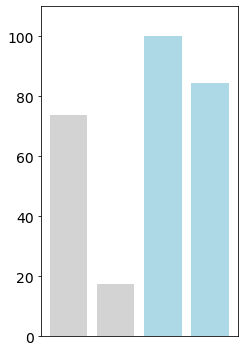

In [45]:
plt.figure(figsize=(3.5,5))
plt.bar(0, 17/23*100, color='lightgray')
plt.bar(1, 4/23*100, color='lightgray')
plt.bar(2, 13/13*100, color='lightblue')
plt.bar(3, 11/13*100, color='lightblue')
plt.xticks([],fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,110)
plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/PK_proximal_negativecurv.pdf")
plt.show()

2.648591863746672 60.114000000000146
3.3080076879929523 60.408000000000015
3.6212348208522407 71
3.0543182417911408 61
2.2410979071972785 60.68900000000002
2.9754527991988384 49.205999999999904
3.268791667621828 60.15699999999998
2.4951685529253145 70.40599999999995
2.378733688779759 71.05899999999997
2.3806333760510876 49.82000000000005
1.9430366268048638 42.30599999999998


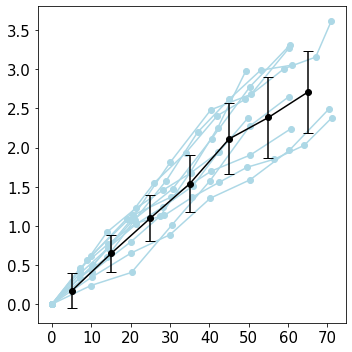

2.7559152029965435 0.49929818357817174 0.15054406667588963
59.651363636363634 8.970398787859052 2.7046769999261238


In [13]:
path = "../../dat/FCPT_manip_20210812/FCPT_2021_microneedle"# FCPT_manip_20210812, WT_manip_20210722
cells = sorted(glob.glob("%s/*"%path))
cells = [cell for cell in cells if not 'Icon' in cell]
# print(len(cells))
dist_lls,time_lls = [],[]
tot_dist,tot_time = [],[]

plt.figure(figsize=(5,5))
for cell in cells:
#     print(cell)
    start_frame = pd.read_csv("%s/manipframe.csv"%cell, header=None).iloc[0,].values[0] - 1
    end_frame = pd.read_csv("%s/manipframe.csv"%cell, header=None).iloc[1,].values[0]
    time_df = pd.read_csv("%s/timelog.csv"%cell, header=None)
#     print(start_frame,end_frame)
    time_arr = time_df.iloc[:,0].values[start_frame:end_frame] - time_df.iloc[:,0].values[start_frame:end_frame][0]
    coord_df = pd.read_csv("%s/Points.csv"%cell)
    x_arr = coord_df["x [micron]"].values
    y_arr = coord_df["y [micron]"].values
    
    time_ls = time_arr.tolist()
    dist_ls=[]
    dist=0
    dist_ls.append(dist)
    for i in range(len(time_arr)-1):
        dist += np.sqrt((x_arr[i+1] - x_arr[i])**2 + (y_arr[i+1] - y_arr[i])**2)*0.0657
        dist_ls.append(dist)
    tot_dist.append(dist_ls[-1])
    tot_time.append(time_ls[-1])
    print(dist_ls[-1],time_ls[-1])
    plt.plot(time_ls,dist_ls,'o-',color='lightblue')
    
    dist_lls.extend(dist_ls)
    time_lls.extend(time_ls)

dist_lls = np.array(dist_lls)
time_lls = np.array(time_lls)

nbins = np.array([0,10,20,30,40,50,60,70])
n, _ = np.histogram(time_lls, bins=nbins)
sy, _ = np.histogram(time_lls, bins=nbins, weights=dist_lls)
sy2, _ = np.histogram(time_lls, bins=nbins, weights=dist_lls*dist_lls)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

# plt.scatter(dist_lls,time_lls, s=70, color='lightblue',ec='k')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='o-',color='k',capsize=5,zorder=10)
# plt.axhline(3,color='k',ls='--')
# plt.title("curvature minima near chromosome")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xlim(0,10)
# plt.ylim(0,10)
plt.tight_layout()
if save_images:
    plt.savefig("fig_outputs/FCPT_microneedlemovement.pdf")
plt.show()
print(np.average(tot_dist),np.std(tot_dist),np.std(tot_dist)/np.sqrt(len(cells)))
print(np.average(tot_time),np.std(tot_time),np.std(tot_time)/np.sqrt(len(tot_time)))



In [ ]:
coord_df

In [57]:
start_frame

,0
0,22
1,28
